# Tutorial 2: Edit Distance

In this tutorial, we look at a more substantial dynamic programming problem: 
computing the edit distance between two strings.
In this notebook, we show how to 

* Construct a dynamic program.
* Assign scores to labels. 
* Compute max-marginal values.

We beging by importing the standard libraries.

In [1]:
import pydecode
import numpy as np
import matplotlib.pyplot as plt

We begin by defining the basic operations available for edit distance, and giving the dynamic program for edit distance.  

In [2]:
kInsert, kDelete, kMatch = 0, 1, 2
operations = np.array([kInsert, kDelete, kMatch])
offsets = np.array([[1,0], [0,1], [1,1]]) 
op_names = np.array(["<",  ">",  "="])

In [20]:
def grid(m, n, o=None):
    if o is None:
        return np.arange(m * n).reshape((m, n))
    else:
        return np.arange(m * n * o).reshape((m, n, o))
grid(5,5)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [22]:
def ungrid(items, shape):
    return np.array(np.unravel_index(items, shape)).T
ungrid([1, 2, 3, 4], (5, 5))

array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4]])

In [5]:
def edit_distance(m, n):

    # Create a grid for the items and labels.
    item_grid = grid(m, n)
    op_grid = grid(m, n, len(operations))
    c = pydecode.ChartBuilder(item_grid)

    # Construct the base cases. 
    c.init(item_grid[0, 0])
    c.init(item_grid[0, 1:])
    c.init(item_grid[1:, 0])
    
    # Construct the recursion.
    for i in range(1, m):
        for j in range(1, n):
            c.set(item_grid[i, j], 
                  [[item_grid[i-1, j]],
                   [item_grid[i, j-1]],
                   [item_grid[i-1, j-1]]],
                  [op_grid[i-1, j, kDelete],
                   op_grid[i, j-1, kInsert],
                   op_grid[i-1, j-1, kMatch]])
    return c.finish()

In [6]:
graph = edit_distance(3, 3)

To get a better sense of this dynamic program, we can visualize its structure. 

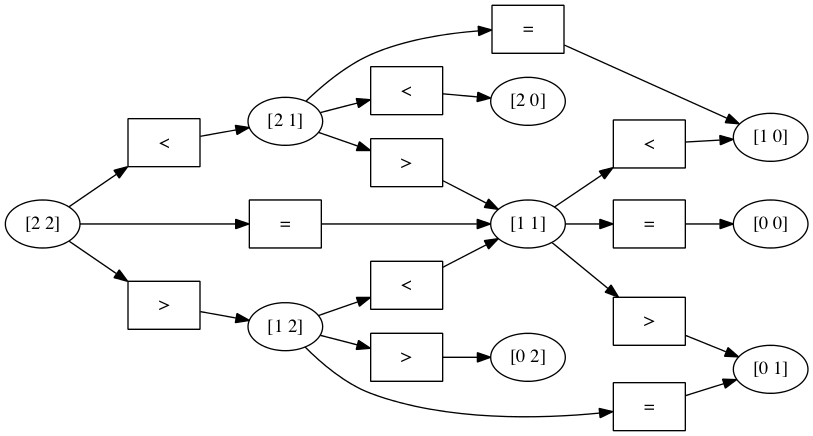

In [7]:
# Construct readable labels for each of the vertices and edges in the graph.
label_names = ungrid(graph.node_labeling, (3,3))
label_ops = op_names[ungrid(graph.labeling, (3,3,3))[:, 2]]
pydecode.draw(graph, label_ops, label_names)
# hyperedge_labels = op_names[pydecode.hyperedge_outputs(dp)[2]]
# display.HypergraphFormatter(dp.hypergraph, vertex_labels=vertex_labels, hyperedge_labels=hyperedge_labels).to_ipython()


In [8]:
def make_scores(string1, string2):
    m, n = len(string1), len(string2)
    scores = np.zeros((m, n, 3))
    for i, s in enumerate(string1):
        for j, t in enumerate(string2):
            scores[i, j, kMatch] = 1.0 if s == t \
                                       else -1e8
    return scores
string1, string2 = "aab", "aac"
scores = make_scores(string1, string2)
weights = pydecode.transform(graph, scores)

Finding the best alignment is simply a matter of calling the argmax function.
This retuns the best outputs under our scoring function. We can then 
transform these into an easier to view format.  

In [9]:
path = pydecode.best_path(graph, weights)
ungrid([edge.label for edge in path.edges], (3,3, 3))
ungrid([node.label for node in path.nodes], (3,3))

array([[0, 0],
       [1, 1],
       [2, 2]])

In [10]:
chart = np.zeros((3,3))
best = ungrid([node.label for node in path.nodes], (3,3))
chart[best.T[:2][0], best.T[:2][1]] = 1
plt.pcolor(chart)
plt.yticks(np.arange(0.5, len(string1), 1), string1)
plt.xticks(np.arange(0.5, len(string2), 1), string2)
None

Furthermore, we can map these scores directly onto the hypergraph, to see 
which path was chosen as the highest scoring.  

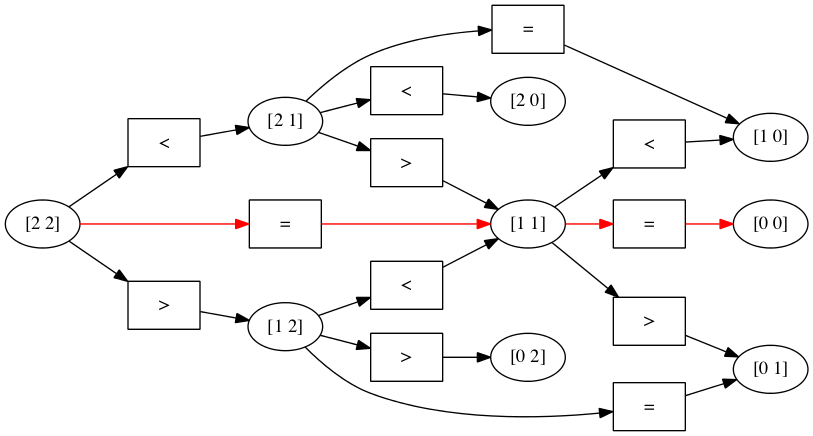

In [11]:
pydecode.draw(graph, label_ops, label_names, paths=[path])

Another common query is for the max-marginals of a given dynamic program. 
The max-marginals given the highest scoring alignment that uses a particular
item or output in the dynamic program. These can be very useful for pruning,
training models, and decoding with partial data. 

In [12]:
np.max(graph.labeling) +1

22

In [13]:
graph.labeling

array([ 4,  9,  2,  7, 12,  5, 13, 18, 11, 16, 21, 14], dtype=int32)

In [14]:

edge_max_marginals = pydecode.marginals(graph, weights)

label_max_marginals = pydecode.inverse_transform(graph, edge_max_marginals, 
                                                 size=3*3*3)

label_max_marginals = label_max_marginals.reshape(3,3,3)

In [15]:
plt.imshow(label_max_marginals[:,:, kMatch])
plt.yticks(np.arange(1.5, len(string1)), string1)
plt.xticks(np.arange(1.5, len(string2)), string2)
None


Finally we look at a longer alignment example.

In [16]:
# strings = np.array(["hllo this is a longer sequence", 
#                     "hello ths is a longr seqence"])
# dp = edit_distance(strings)
# output_scores = make_scores(strings, dp.outputs)
# best = pydecode.argmax(dp, output_scores)

In [17]:
# chart = np.zeros(dp.items.shape)
# chart[best.T[:2][0], best.T[:2][1]] = 1

In [18]:
# plt.imshow(chart)
# plt.yticks(np.arange(1.5, len(strings[0])+1, 1), strings[0])
# plt.xticks(np.arange(1.5, len(strings[1])+1, 1), strings[1])
# None